Epoch 0, Loss: 0.30799004435539246
Epoch 500, Loss: 0.0004476900794543326
Epoch 1000, Loss: 8.571281068725511e-05
Epoch 1500, Loss: 2.5435865609324537e-05
Epoch 2000, Loss: 1.0806440513988491e-05
Epoch 2500, Loss: 0.001234863419085741
Epoch 3000, Loss: 5.276369847706519e-06
Epoch 3500, Loss: 0.002580164698883891
Epoch 4000, Loss: 3.858367563225329e-06
Epoch 4500, Loss: 3.025853402505163e-06


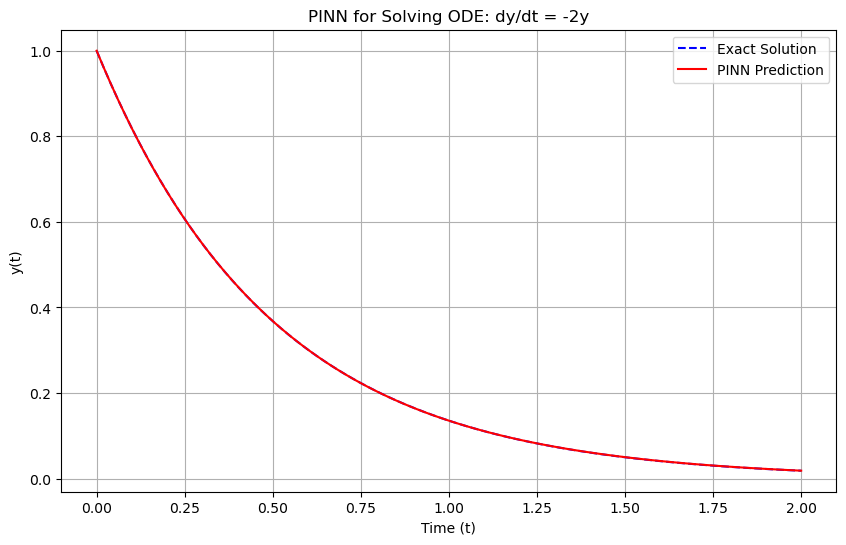

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the ODE: dy/dt = -2y
def ode_func(t, y):
    return -2 * y

# Define the exact solution: y(t) = exp(-2t)
def exact_solution(t):
    return np.exp(-2 * t)

# Create the training data
t_train = np.linspace(0, 2, 100)  # Time values for training
y_train_exact = exact_solution(t_train)

# Neural Network Model for PINN
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(64, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, t):
        x = self.dense1(t)
        x = self.dense2(x)
        y = self.output_layer(x)
        return y

# Define the loss function that incorporates the ODE
def loss_fn(model, t, y_exact):
    # Compute the predicted values of y
    y_pred = model(t)
    
    # Use GradientTape outside of the context
    with tf.GradientTape() as tape:
        tape.watch(t)
        y_pred = model(t)  # Predict again inside the tape context
    y_prime_pred = tape.gradient(y_pred, t)  # Compute dy/dt using GradientTape
    
    # ODE loss: dy/dt + 2y
    ode_loss = tf.reduce_mean(tf.square(y_prime_pred + 2 * y_pred))  
    # Data loss: |y_pred - y_exact|
    data_loss = tf.reduce_mean(tf.square(y_pred - y_exact))  
    
    return ode_loss + data_loss

# Train the model
model = PINN()
optimizer = tf.optimizers.Adam(learning_rate=0.001)

epochs = 5000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        t_tensor = tf.convert_to_tensor(t_train.reshape(-1, 1), dtype=tf.float32)
        y_exact_tensor = tf.convert_to_tensor(y_train_exact.reshape(-1, 1), dtype=tf.float32)
        
        loss = loss_fn(model, t_tensor, y_exact_tensor)
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

# Predict the solution from the trained model
y_pred_train = model(tf.convert_to_tensor(t_train.reshape(-1, 1), dtype=tf.float32)).numpy()

# Plot the exact solution and the model's prediction
plt.figure(figsize=(10, 6))
plt.plot(t_train, y_train_exact, label='Exact Solution', linestyle='--', color='blue')
plt.plot(t_train, y_pred_train, label='PINN Prediction', linestyle='-', color='red')
plt.xlabel('Time (t)')
plt.ylabel('y(t)')
plt.legend()
plt.title('PINN for Solving ODE: dy/dt = -2y')
plt.grid(True)
plt.show()
